Trying to verify the predictions [here](https://ttw-public.notion.site/Datamodels-Per-datapoint-cliff-learning-491c8467f85e4d61be0026c1adb8b1d7).

### Load libraries

In [3]:
import pathlib
import sys
import tempfile
from typing import Any

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import transformers
import wandb
import wandb.apis.public
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

transformers.logging.set_verbosity_error()

### Load wandb data

In [5]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/resnet-scaling",
    filters={"tags": {"$in": ["try-1", "try-1.1"]}},
)


def get_df_from_run(run_id: str) -> dict[str, Any]:
    api = wandb.Api(timeout=30)
    run = api.run(f"data-frugal-learning/resnet-scaling/{run_id}")

    def flatten_dict(d: dict, prefix: str = "") -> dict:
        ret = dict()
        for k, v in d.items():
            if isinstance(v, dict):
                ret |= flatten_dict(v, prefix=f"{k}_")
            else:
                ret[f"{prefix}{k}"] = v
        return ret

    ret_dict = (
        flatten_dict(run.summary._json_dict)  # type: ignore
        | flatten_dict(run.config)
        | {
            "id": run.id,
            "run_path": "/".join(run.path),
            "name": run.name,
            "state": run.state,
        }
    )

    # Download per-sample losses
    wf: wandb.apis.public.File = run.file("per_sample_losses.npy")
    with tempfile.TemporaryDirectory() as td:
        with open(wf.download(root=td).name, "rb") as file:
            ret_dict["per_sample_losses"] = np.load(file)

    return ret_dict

ret_dicts = process_map(
    get_df_from_run,
    [r.id for r in runs],
    max_workers=14,  # https://docs.wandb.ai/guides/track/limits
    tqdm_class=tqdm,
)
df = pd.DataFrame(ret_dicts)
df["test_err"] = 1 - df.test_acc

  0%|          | 0/40 [00:00<?, ?it/s]

### Basic scaling data

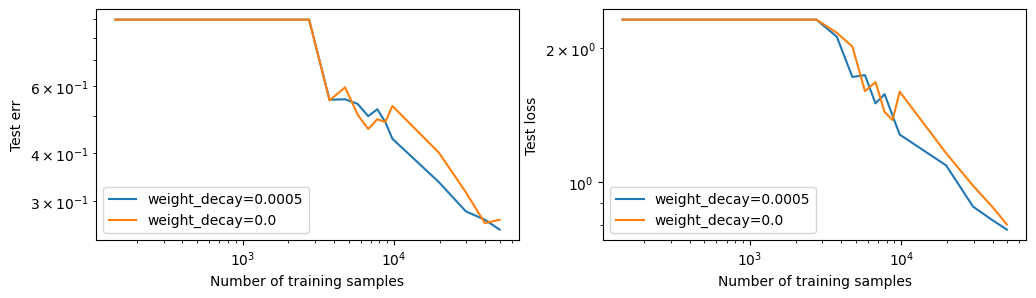

In [23]:
plt.figure(figsize=(12, 3))
for i, target in enumerate(["err", "loss"]):
    plt.subplot(1, 2, i + 1)
    for weight_decay in df.weight_decay.unique():
        cdf = (
            df.query("weight_decay == @weight_decay")
            .sort_values("n_train")
            .reset_index(drop=True)
        )
        # plt.plot(cdf.n_train, 1 - cdf.test_acc, label=f"{weight_decay=}")
        plt.plot(
            cdf.n_train - cdf.n_val_override,
            cdf[f"test_{target}"],
            label=f"{weight_decay=}",
        )

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Number of training samples")
    plt.ylabel(f"Test {target}")
    plt.legend()


### Per sample loss curve

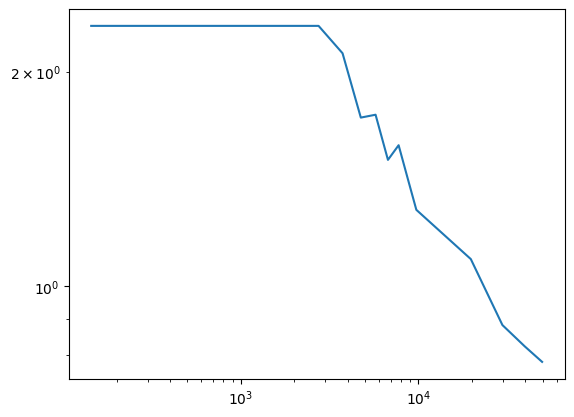

In [49]:
cdf = (
    df.query("weight_decay == 0.0005")
    .sort_values("n_train")
    .reset_index(drop=True)
)

n_trains = cdf.n_train - cdf.n_val_override
per_sample_losses = np.stack(cdf.per_sample_losses)
plt.plot(n_trains, per_sample_losses.mean(axis=1))


plt.xscale("log")
plt.yscale("log")

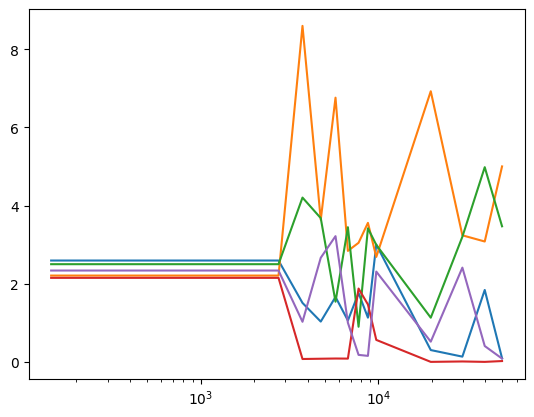

In [53]:
cdf = (
    df.query("weight_decay == 0.0005")
    .sort_values("n_train")
    .reset_index(drop=True)
)

n_trains = cdf.n_train - cdf.n_val_override
per_sample_losses = np.stack(cdf.per_sample_losses)

start_idx = 1505
for i in range(start_idx, start_idx + 5):
    plt.plot(n_trains, per_sample_losses[:, i], label=f"Sample {i}")

plt.xscale("log")
# plt.yscale("log")
